<a href="https://colab.research.google.com/github/Steve-YJ/Colab_Exercise/blob/master/02_Tutorial_ResNet_VAE_Tunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# README.MD

* Post-InfoSec-Exp
* Continue:
    * 01.Tutorial-ResNet-VAE -Epoch5
    * Reduce Learning Rate


* mount drive

In [1]:
# drive mount

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%cd drive/My\ Drive/Post_InfoSec_Exps/ResNet-VAE/ResNetVAE-master.zip (Unzipped Files)/ResNetVAE-master
! ls

/content/drive/My Drive/Post_InfoSec_Exps/ResNet-VAE/ResNetVAE-master.zip (Unzipped Files)/ResNetVAE-master
'01.Tutorial-ResNet-VAE.ipynb의 사본'   README.md
 01.Tutorial-ResNet-VAE-Recon.ipynb     recon_sampling
 02.Tutorial-ResNet-VAE-Tunning.ipynb   reconstruction_Malimg.png
 fig				        ResNetVAE_cifar10.py
 generated_Malimg.png		        ResNetVAE_FACE.py
 modules.py			        ResNetVAE_MNIST.py
 plot_latent.ipynb		        ResNetVAE_reconstruction.ipynb
 plot_latent_vector		        results_Malimg
 plot_train_test_loss		        results_Malimg_Exp2
 __pycache__


In [4]:
import os

path = os.getcwd()
path

'/content/drive/My Drive/Post_InfoSec_Exps/ResNet-VAE/ResNetVAE-master.zip (Unzipped Files)/ResNetVAE-master'

In [26]:
'''
# make directory
# 실험을 한 번 끝낸 이후로는 사용 x

def makedir(dirname):
    
    try:
        os.mkdir(path + '/' + dirname)
    except OSError:
        print("Creation of the directory %s failed" % path)
    else:
        print("Successfully created the directory %s" % path)
    return

dir_list = ['recon_sampling', 'plot_train_test_loss', 'plot_latent_vector']

for i in range(len(dir_list)):
    print(dir_list[i])
    print(path + '/' + dir_list[i])
    makedir(dir_list[i])


! ls
'''

recon_sampling
/content/drive/My Drive/Post_InfoSec_Exps/ResNet-VAE/ResNetVAE-master.zip (Unzipped Files)/ResNetVAE-master/recon_sampling
Successfully created the directory /content/drive/My Drive/Post_InfoSec_Exps/ResNet-VAE/ResNetVAE-master.zip (Unzipped Files)/ResNetVAE-master
plot_train_test_loss
/content/drive/My Drive/Post_InfoSec_Exps/ResNet-VAE/ResNetVAE-master.zip (Unzipped Files)/ResNetVAE-master/plot_train_test_loss
Successfully created the directory /content/drive/My Drive/Post_InfoSec_Exps/ResNet-VAE/ResNetVAE-master.zip (Unzipped Files)/ResNetVAE-master
plot_latent_vector
/content/drive/My Drive/Post_InfoSec_Exps/ResNet-VAE/ResNetVAE-master.zip (Unzipped Files)/ResNetVAE-master/plot_latent_vector
Successfully created the directory /content/drive/My Drive/Post_InfoSec_Exps/ResNet-VAE/ResNetVAE-master.zip (Unzipped Files)/ResNetVAE-master
'01.Tutorial-ResNet-VAE.ipynb의 사본'   README.md
 01.Tutorial-ResNet-VAE-Recon.ipynb     recon_sampling
 02.Tutorial-ResNet-VAE-Tunning

## 01. Import Library

In [5]:
from PIL import Image
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
 
# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
import seaborn as sns

# save single numpy array
# https://numpy.org/doc/stable/reference/generated/numpy.save.html#numpy.save
from tempfile import TemporaryFile
from sklearn.manifold import TSNE

import torch
import torch.utils.data

from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

# load modules
from torchvision import models
from modules import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 02. Data Preparation
* Make Custom Dataset
* Make Custom DataLoader
* Train_Test Split

### Work Flow
* transforms module 사용, Image data compose(전처리, transform)
* re-sizing, normalizing, tensor
* ImageFolder사용 dataloader
* dataset split: train dataset, test dataset
* DataLoader: batch단위 dataset loading

In [6]:
transforms = transforms.Compose([
                                transforms.Resize((224, 224)),                # Change size of Image to (224, 224)
                                transforms.Grayscale(num_output_channels=3),  # Makes it 3-dimension channel
                                                                              # Simple way
                                                                              # https://pytorch.org/docs/stable/torchvision/transforms.html
                                                                              # If num_output_channels == 3 : returned image is 3 channel with r == g == b
                                 
                                # transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # gray -> GRB 3 channel (lambda function)
                                                                                 # Reference: https://github.com/hsinyilin19/ResNetVAE/blob/master/ResNetVAE_MNIST.py
                                transforms.ToTensor(),                        # Convert a PIL Image or numpy.ndarray to tensor.
                                                                              # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype = np.uint8
                                                                              # In the other cases, tensors are returned without scaling.
                                # transforms.Normalize(mean=[0.5], std=[0.5]), 
                                ])

# make custom dataset
trainset = torchvision.datasets.ImageFolder(root='../../../../InformationSecurity_Summer/malimg',
                                            transform=transforms)  # make custom dataset

In [7]:
# classes = trainset.classes
classes = trainset.classes
classes

['Adialer.C',
 'Agent.FYI',
 'Allaple.A',
 'Allaple.L',
 'Alueron.gen!J',
 'Autorun.K',
 'C2LOP.P',
 'C2LOP.gen!g',
 'Dialplatform.B',
 'Dontovo.A',
 'Fakerean',
 'Instantaccess',
 'Lolyda.AA1',
 'Lolyda.AA2',
 'Lolyda.AA3',
 'Lolyda.AT',
 'Malex.gen!J',
 'Obfuscator.AD',
 'Rbot!gen',
 'Skintrim.N',
 'Swizzor.gen!E',
 'Swizzor.gen!I',
 'VB.AT',
 'Wintrim.BX',
 'Yuner.A']

In [8]:
full_dataset = trainset
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
print(train_size, test_size)

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

7471 1868


In [9]:
train_loader = DataLoader(train_dataset,
                         batch_size=16,
                         shuffle=True,
                         pin_memory=True) 
valid_loader = DataLoader(test_dataset,
                        batch_size=16,
                        shuffle=True,
                        pin_memory=True)  # Instead, we recommend using automatic memory pinning (i.e., setting pin_memory=True)
                                          #  which enables fast data transfer to CUDA-enabled GPUs

# First, insert all test dataset
# test_loader_10: testloader for latent vector visualization
test_loader_10 = DataLoader(test_dataset,
                        batch_size=1868,
                        shuffle=True,
                        pin_memory=True)

### 3-Channel Image를 출력해보자
* -20.07.30.Thur-

In [10]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    np_img = img.numpy()

    plt.imshow(np.transpose(np_img, (1, 2, 0)))  # Convert (C, W, H) to (W, H, C)

    print(np_img.shape)  # np_img shape
    print((np.transpose(np_img, (1, 2, 0))).shape)  # transposed shape 

In [11]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(labels)

tensor([ 3, 12,  2,  7,  2, 10, 22,  2, 22,  3,  8,  3, 10, 17,  2,  9])


torch.Size([16, 3, 224, 224])
(3, 906, 906)
(906, 906, 3)
torch.Size([16, 3, 224, 224])
torch.Size([3, 454, 1810])
Allaple.L Lolyda.AA1 Allaple.A C2LOP.gen!g Allaple.A Fakerean VB.AT Allaple.A VB.AT Allaple.L Dialplatform.B Allaple.L Fakerean Obfuscator.AD Allaple.A Dontovo.A 


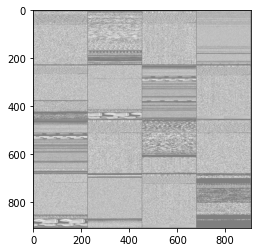

In [12]:
print(images.shape)
imshow(torchvision.utils.make_grid(images, nrow=4))
print(images.shape)
print((torchvision.utils.make_grid(images)).shape)
print("".join("%5s "%classes[labels[j]] for j in range(16)))

## 03. Modeling
* save model: <code>save_model_path</code>
* save_loss_list
* etc...


* Hyper Parameters
    * CNN_fc_hidden1, CNN_fc_hidden2 = 1024, 1024
    * CNN_embed_dim = 256  # latent dim extracted by 2D CNN
    * res_size = 224  # ResNet image size
    * dropout_p = 0.2  # dropout probability
    * Epochs = 50
    * batch_size = 16
    * learning_rate = 1e-5
    * log_interval = 10  # The time between data samples being taken

In [27]:
# EncoderCNN architecture
CNN_fc_hidden1, CNN_fc_hidden2 = 1024, 1024
CNN_embed_dim = 256     # latent dim extracted by 2D CNN
res_size = 224        # ResNet image size
dropout_p = 0.2       # dropout probability

# training parameters
epochs = 50        # training epochs
batch_size = 8
learning_rate = 1e-5
log_interval = 10   # interval for displaying training info

In [14]:
# save model
save_model_path = './results_Malimg_Exp2'  # save_model parameter

In [15]:
def check_mkdir(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)

In [23]:
def check_mkdir(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)

def loss_function(recon_x, x, mu, logvar):
    # MSE = F.mse_loss(recon_x, x, reduction='sum')
    MSE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # mse, kld의 값도 확인하고 싶은데... 어떻게 하면 좋을까??
    # Loss Function 호출시마다 값을 저장해준다
    mse_loss.append(MSE)
    kld_loss.append(KLD)

    return MSE + KLD

In [17]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    # set model as training mode
    model.train()

    losses = []
    all_y, all_z, all_mu, all_logvar = [], [], [], []
    N_count = 0   # counting total trained sample in one epoch
    for batch_idx, (X, y) in enumerate(train_loader):
        # distribute data to device
        X, y = X.to(device), y.to(device).view(-1, )
        N_count += X.size(0)

        optimizer.zero_grad()
        X_reconst, z, mu, logvar = model(X)  # VAE
        # calc loss
        loss = loss_function(X_reconst, X, mu, logvar)
        losses.append(loss.item())
        # backward()
        loss.backward()
        # optimize
        optimizer.step()

        all_y.extend(y.data.cpu().numpy())
        all_z.extend(z.data.cpu().numpy())
        all_mu.extend(mu.data.cpu().numpy())
        all_logvar.extend(logvar.data.cpu().numpy())

        # show information
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 5 +1, N_count, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item()))

    all_y = np.stack(all_y, axis=0)
    all_z = np.stack(all_z, axis=0)
    all_mu = np.stack(all_mu, axis=0)
    all_logvar = np.stack(all_logvar, axis=0)

    # save Pytorch models of best record
    torch.save(model.state_dict(), os.path.join(save_model_path, 'model_epoch{}.pth'.format(epoch +5 + 1)))  # save motion_encoder
    torch.save(optimizer.state_dict(), os.path.join(save_model_path, 'optimizer_epoch{}.pth'.format(epoch +5 + 1)))      # save optimizer
    print("Epoch {} model saved!".format(epoch + 5 +1))  # 5 Epoch부터 이어서 Training하기 때문

    return X.data.cpu().numpy(), all_y, all_z, all_mu, all_logvar, losses


def validation(model, device, optimizer, test_loader):
    # set model as testing mode
    model.eval()  # set testing mode: model.eva()

    test_loss = 0
    all_y, all_z, all_mu, all_logvar = [], [], [], []
    with torch.no_grad():  # gradient 추적을 하지 않는다고 우선 선언
        for X, y in test_loader:
            # distribute data to device
            X, y = X.to(device), y.to(device).view(-1, )
            X_reconst, z, mu, logvar = model(X)
            # calc loss
            loss = loss_function(X_reconst, X, mu, logvar)
            test_loss += loss.item()  # sum up batch loss
            
            all_y.extend(y.data.cpu().numpy())
            all_z.extend(z.data.cpu().numpy())
            all_mu.extend(mu.data.cpu().numpy())
            all_logvar.extend(logvar.data.cpu().numpy())
        

    ## Save_Recon_Malimg
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            # recon_batch, mu, logvar, z = model(data)
            recon, z, mu, logvar = model(data)

            # z vector는 torch type
            # latent_vector = z.detach().cpu().clone().numpy()

            # test_loss += loss_function(recon, data, mu, logvar).item()  # 중복됨
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                    recon.view(16, 3, 224, 224)[:n]])
                save_image(comparison.cpu(),
                        './recon_sampling/reconstruction_' + str(epoch+5) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    all_y = np.stack(all_y, axis=0)
    all_z = np.stack(all_z, axis=0)
    all_mu = np.stack(all_mu, axis=0)
    all_logvar = np.stack(all_logvar, axis=0)

    # show information
    print('\nTest set ({:d} samples): Average loss: {:.4f}\n'.format(len(test_loader.dataset), test_loss))
    return X.data.cpu().numpy(), all_y, all_z, all_mu, all_logvar, test_loss


In [18]:
# Detect devices
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU

### Load_State_Dict
* 이전 학습에서 저장했던 model parameter를 불러온다<br>


<code>pre_saved_model_path</code>: 지난번 1e-3에서 5Epoch학습한 모델의 파라미터

In [19]:
pre_saved_model_path = './results_Malimg'
epoch = 5

# reload ResNetVAE model
resnet_vae = ResNet_VAE(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p, CNN_embed_dim=CNN_embed_dim).to(device)
resnet_vae.load_state_dict(torch.load(os.path.join(pre_saved_model_path, 'model_epoch{}.pth'.format(epoch))))
print("ResNet VAE epoch {} model reloaded!".format(epoch))

ResNet VAE epoch 5 model reloaded!


In [20]:
# resnet_vae = ResNet_VAE(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p, CNN_embed_dim=CNN_embed_dim).to(device)

print("Using", torch.cuda.device_count(), "GPU!")
model_params = list(resnet_vae.parameters())
optimizer = torch.optim.Adam(model_params, lr=learning_rate)  # After5 lr 1e-3 to 1e-5


Using 1 GPU!


In [21]:
# record training process
'''
list_epoch = []
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []
'''
list_epoch=[]
epoch_train_losses = []
epoch_test_losses = []
mse_loss = []
kld_loss = []
list_acc = []
list_acc_epoch =[]
check_mkdir(save_model_path)

## 04. Train-it

In [28]:
# start training
for epoch in range(epochs):

    # train, test model
    X_train, y_train, z_train, mu_train, logvar_train, train_losses = train(log_interval, resnet_vae, device, train_loader, optimizer, epoch)
    X_test, y_test, z_test, mu_test, logvar_test, epoch_test_loss = validation(resnet_vae, device, optimizer, valid_loader)

    # save results
    list_epoch.append(epoch)
    epoch_train_losses.append(train_losses)
    epoch_test_losses.append(epoch_test_loss)

    
    # save all train test results
    A = np.array(epoch_train_losses)
    C = np.array(epoch_test_losses)
    
    np.save(os.path.join(save_model_path, 'ResNet_VAE_training_loss.npy'), A)
    np.save(os.path.join(save_model_path, 'X_Malimg_train_epoch{}.npy'.format(epoch + 1)), X_train) #save last batch
    np.save(os.path.join(save_model_path, 'y_Malimg_train_epoch{}.npy'.format(epoch + 1)), y_train)
    np.save(os.path.join(save_model_path, 'z_Malimg_train_epoch{}.npy'.format(epoch + 1)), z_train)


RuntimeError: ignored

In [25]:
! nvidia-smi

Thu Jul 30 03:06:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    39W / 250W |  16257MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### plot_train_val_loss plot

In [ ]:
fig = plt.figure(figsize=(15, 5))

# ======= Loss Fluctuation ======= #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, epoch_train_losses, label='train_loss')
ax1.plot(list_epoch, epoch_test_losses, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

plt.savefig('./plot_latent_vector/' + str(epoch+5) + '_t_SNE.png', dpi=300)


'''
# ======= Metric Fluctuation ======= # 
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()
'''